In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Conv1D, TimeDistributed, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
file_path = 'dataset_location'
data = pd.read_csv(file_path)

In [ ]:
data.head()

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
0,Alkoholunfälle,insgesamt,2023,202301,NaN,NaN,NaN,NaN,NaN
1,Alkoholunfälle,insgesamt,2023,202302,NaN,NaN,NaN,NaN,NaN
2,Alkoholunfälle,insgesamt,2023,202303,NaN,NaN,NaN,NaN,NaN
3,Alkoholunfälle,insgesamt,2023,202304,NaN,NaN,NaN,NaN,NaN
4,Alkoholunfälle,insgesamt,2023,202305,NaN,NaN,NaN,NaN,NaN


In [ ]:
min_year = data['JAHR'].min()
max_year = data['JAHR'].max()

print(f"Minimum year in the dataset: {min_year}")
print(f"Maximum year in the dataset: {max_year}")

Minimum year in the dataset: 2000
Maximum year in the dataset: 2023


In [ ]:
data['MONAT'] = data['MONAT'].astype(str).str[:6]
data['DATUM'] = pd.to_datetime(data['MONAT'], format='%Y%m')
data = data[data['JAHR'] <= 2020]

In [ ]:
data.head()

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT,DATUM
36,Alkoholunfälle,insgesamt,2020,202001,28.0,22.0,-20.00,27.27,37.0,2020-01-01
37,Alkoholunfälle,insgesamt,2020,202002,40.0,28.0,42.86,42.86,38.0,2020-02-01
38,Alkoholunfälle,insgesamt,2020,202003,27.0,34.0,-32.50,-20.59,37.0,2020-03-01
39,Alkoholunfälle,insgesamt,2020,202004,26.0,36.0,-3.70,-27.78,36.0,2020-04-01
40,Alkoholunfälle,insgesamt,2020,202005,40.0,39.0,53.85,2.56,36.0,2020-05-01


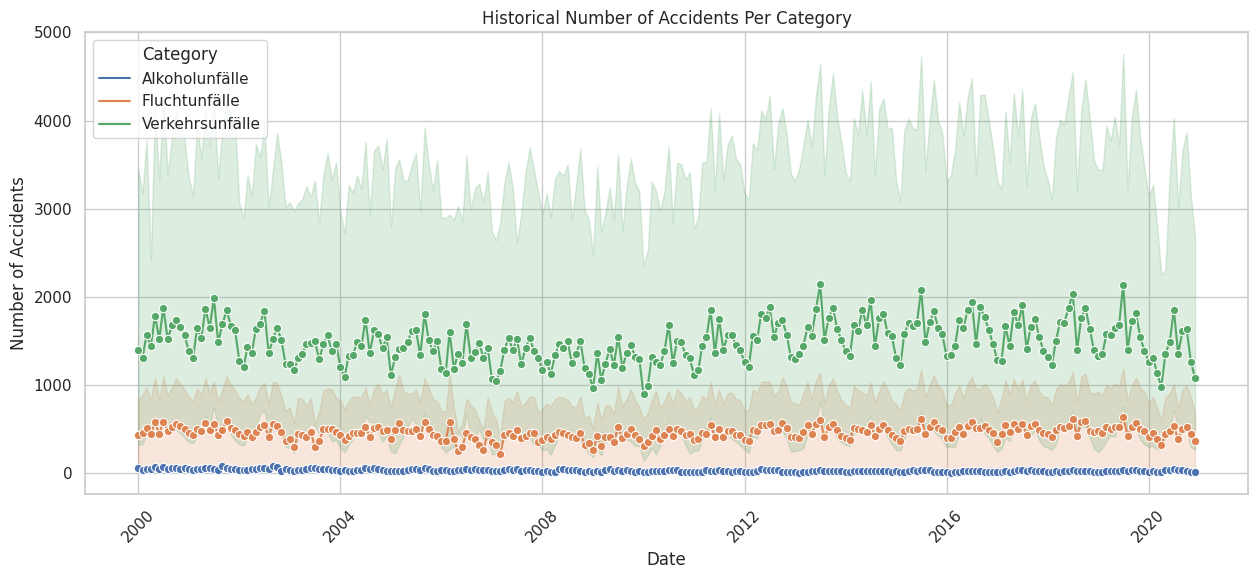

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(15, 6))
sns.lineplot(x='DATUM', y='WERT', hue='MONATSZAHL', data=data, marker='o')
plt.title('Historical Number of Accidents Per Category')
plt.xlabel('Date')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.legend(title='Category', loc='upper left')
plt.show()

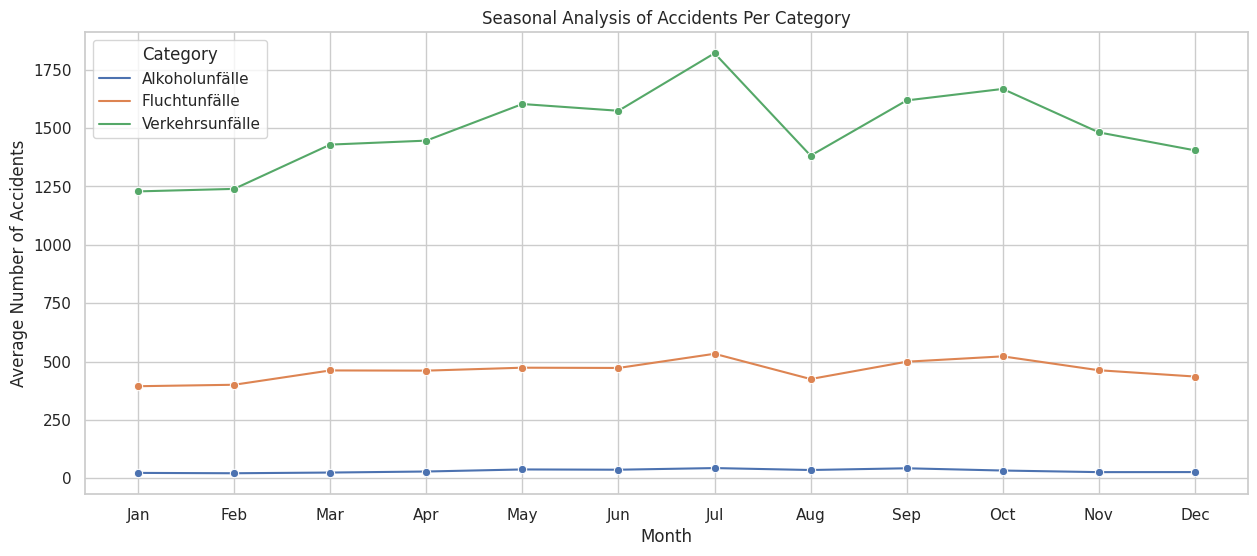

In [ ]:
monthly_data = data.groupby(['MONATSZAHL', data['DATUM'].dt.month])['WERT'].mean().reset_index()
plt.figure(figsize=(15, 6))
sns.lineplot(x='DATUM', y='WERT', hue='MONATSZAHL', data=monthly_data, marker='o')
plt.title('Seasonal Analysis of Accidents Per Category')
plt.xlabel('Month')
plt.ylabel('Average Number of Accidents')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Category', loc='upper left')
plt.show()

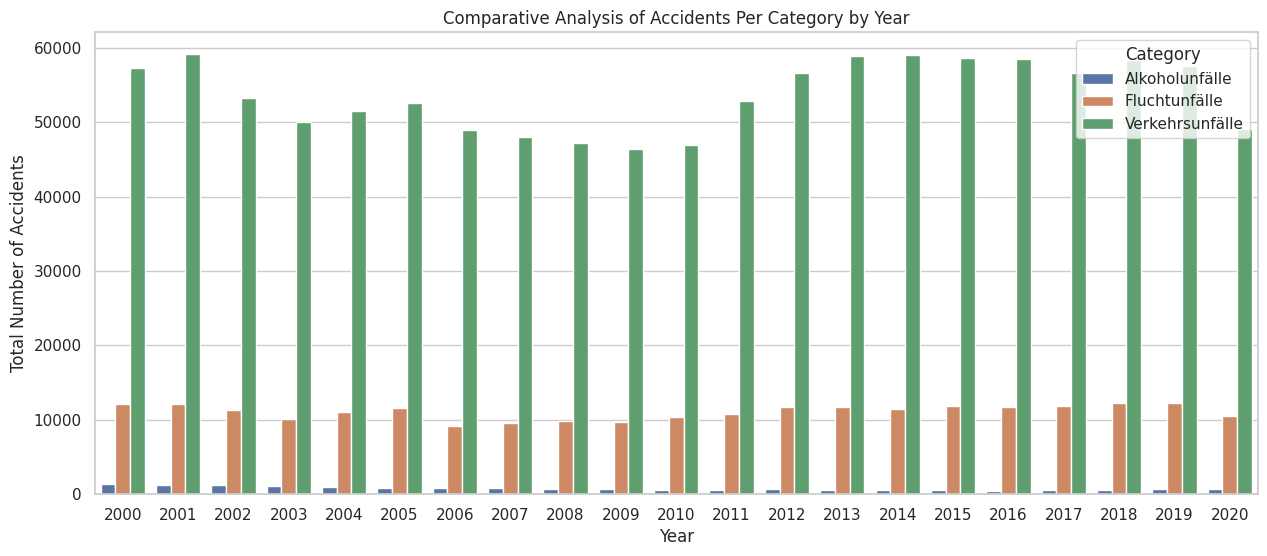

In [ ]:
yearly_data = data.groupby(['MONATSZAHL', 'JAHR'])['WERT'].sum().reset_index()
plt.figure(figsize=(15, 6))
sns.barplot(x='JAHR', y='WERT', hue='MONATSZAHL', data=yearly_data)
plt.title('Comparative Analysis of Accidents Per Category by Year')
plt.xlabel('Year')
plt.ylabel('Total Number of Accidents')
plt.legend(title='Category', loc='upper right')
plt.show()

In [ ]:
filtered_data = data[(data['MONATSZAHL'] == 'Alkoholunfälle') & (data['AUSPRAEGUNG'] == 'insgesamt') & (data['JAHR'] <= 2020)]
series = filtered_data.set_index('DATUM')['WERT'].dropna().values.reshape(-1, 1)

In [ ]:
series_reshaped = series.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(series_reshaped)

def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length + 1])
    return np.array(sequences)

sequence_length = 5 
sequences = create_sequences(scaled_data, sequence_length)
X, y = sequences[:, :-1], sequences[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(100, return_sequences=True),
    LSTM(100),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

predicted = model.predict(X_test)

predicted = scaler.inverse_transform(predicted)

Epoch 1/100
6/6 [==============================] - 9s 315ms/step - loss: 0.1093 - val_loss: 0.0370
Epoch 2/100
6/6 [==============================] - 0s 20ms/step - loss: 0.0357 - val_loss: 0.0417
Epoch 3/100
6/6 [==============================] - 0s 20ms/step - loss: 0.0272 - val_loss: 0.0193
Epoch 4/100
6/6 [==============================] - 0s 22ms/step - loss: 0.0266 - val_loss: 0.0193
Epoch 5/100
6/6 [==============================] - 0s 21ms/step - loss: 0.0237 - val_loss: 0.0206
Epoch 6/100
6/6 [==============================] - 0s 22ms/step - loss: 0.0224 - val_loss: 0.0180
Epoch 7/100
6/6 [==============================] - 0s 20ms/step - loss: 0.0213 - val_loss: 0.0167
Epoch 8/100
6/6 [==============================] - 0s 21ms/step - loss: 0.0210 - val_loss: 0.0166
Epoch 9/100
6/6 [==============================] - 0s 20ms/step - loss: 0.0200 - val_loss: 0.0173
Epoch 10/100
6/6 [==============================] - 0s 21ms/step - loss: 0.0202 - val_loss: 0.0161
Epoch 11/100
6/6 [

In [ ]:
y_test_original = scaler.inverse_transform(y_test)

comparison = pd.DataFrame({'Original': y_test_original.flatten(), 'Predicted': predicted.flatten()})
print(comparison)

    Original  Predicted
0       36.0  25.021986
1       13.0  30.385088
2       63.0  46.520622
3       39.0  38.801231
4       63.0  39.893520
5       40.0  38.578175
6       58.0  55.943336
7       25.0  28.316133
8       34.0  27.244930
9       66.0  71.336273
10     107.0  57.809719
11      61.0  41.827644
12      73.0  56.501881
13      48.0  47.804905
14      27.0  30.605904
15      63.0  60.495987
16     107.0  70.101730
17      47.0  38.372112
18      48.0  53.165730
19      39.0  32.976112
20      39.0  35.263550
21      22.0  35.034191
22      26.0  35.113201
23      21.0  28.783381
24      44.0  85.634262
25      51.0  48.902557
26      55.0  47.920155
27      36.0  32.413704
28      21.0  34.918293
29      43.0  39.639137
30      78.0  61.284119
31      77.0  75.246971
32      31.0  28.551756
33      51.0  35.698784
34      83.0  75.290466
35      35.0  36.797977
36      31.0  42.715725
37      52.0  55.174164
38      22.0  26.687773
39      20.0  25.879084
40      74.0  56

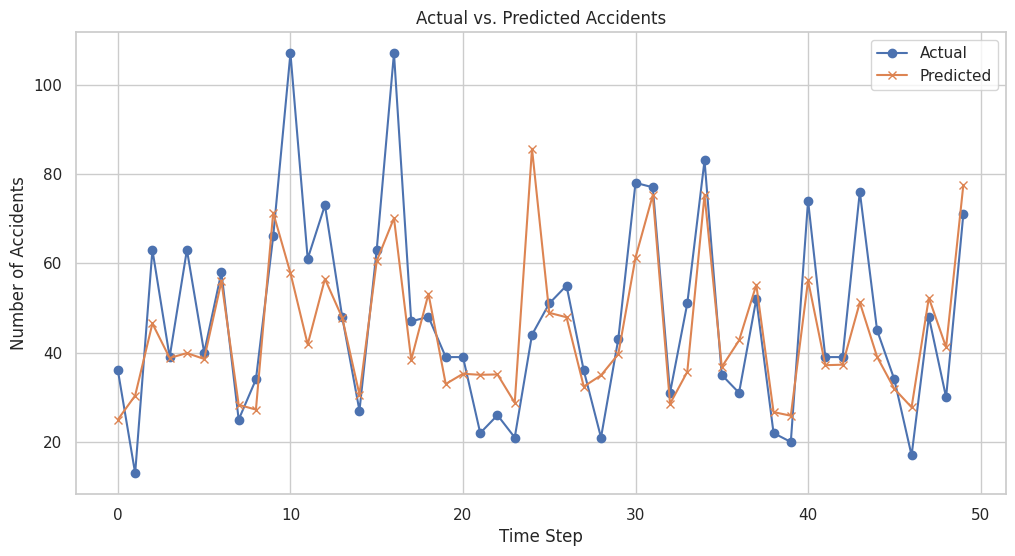

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label='Actual', marker='o')
plt.plot(predicted, label='Predicted', marker='x')
plt.title('Actual vs. Predicted Accidents')
plt.xlabel('Time Step')
plt.ylabel('Number of Accidents')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model_2 = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    LSTM(128, return_sequences=False),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(1)
])

model_2.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

model_2.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

predicted = model.predict(X_test)

predicted = scaler.inverse_transform(predicted)

Epoch 1/100
6/6 [==============================] - 9s 266ms/step - loss: 0.1136 - val_loss: 0.0806
Epoch 2/100
6/6 [==============================] - 0s 26ms/step - loss: 0.0388 - val_loss: 0.0533
Epoch 3/100
6/6 [==============================] - 0s 26ms/step - loss: 0.0292 - val_loss: 0.0450
Epoch 4/100
6/6 [==============================] - 0s 30ms/step - loss: 0.0206 - val_loss: 0.0317
Epoch 5/100
6/6 [==============================] - 0s 26ms/step - loss: 0.0163 - val_loss: 0.0296
Epoch 6/100
6/6 [==============================] - 0s 26ms/step - loss: 0.0157 - val_loss: 0.0297
Epoch 7/100
6/6 [==============================] - 0s 26ms/step - loss: 0.0158 - val_loss: 0.0284
Epoch 8/100
6/6 [==============================] - 0s 27ms/step - loss: 0.0146 - val_loss: 0.0300
Epoch 9/100
6/6 [==============================] - 0s 27ms/step - loss: 0.0147 - val_loss: 0.0290
Epoch 10/100
6/6 [==============================] - 0s 29ms/step - loss: 0.0153 - val_loss: 0.0264
Epoch 11/100
6/6 [

In [ ]:
y_test_original = scaler.inverse_transform(y_test)

comparison = pd.DataFrame({'Original': y_test_original.flatten(), 'Predicted': predicted.flatten()})
print(comparison)

    Original  Predicted
0       36.0  25.021986
1       13.0  30.385088
2       63.0  46.520622
3       39.0  38.801231
4       63.0  39.893520
5       40.0  38.578175
6       58.0  55.943336
7       25.0  28.316133
8       34.0  27.244930
9       66.0  71.336273
10     107.0  57.809719
11      61.0  41.827644
12      73.0  56.501881
13      48.0  47.804905
14      27.0  30.605904
15      63.0  60.495987
16     107.0  70.101730
17      47.0  38.372112
18      48.0  53.165730
19      39.0  32.976112
20      39.0  35.263550
21      22.0  35.034191
22      26.0  35.113201
23      21.0  28.783381
24      44.0  85.634262
25      51.0  48.902557
26      55.0  47.920155
27      36.0  32.413704
28      21.0  34.918293
29      43.0  39.639137
30      78.0  61.284119
31      77.0  75.246971
32      31.0  28.551756
33      51.0  35.698784
34      83.0  75.290466
35      35.0  36.797977
36      31.0  42.715725
37      52.0  55.174164
38      22.0  26.687773
39      20.0  25.879084
40      74.0  56

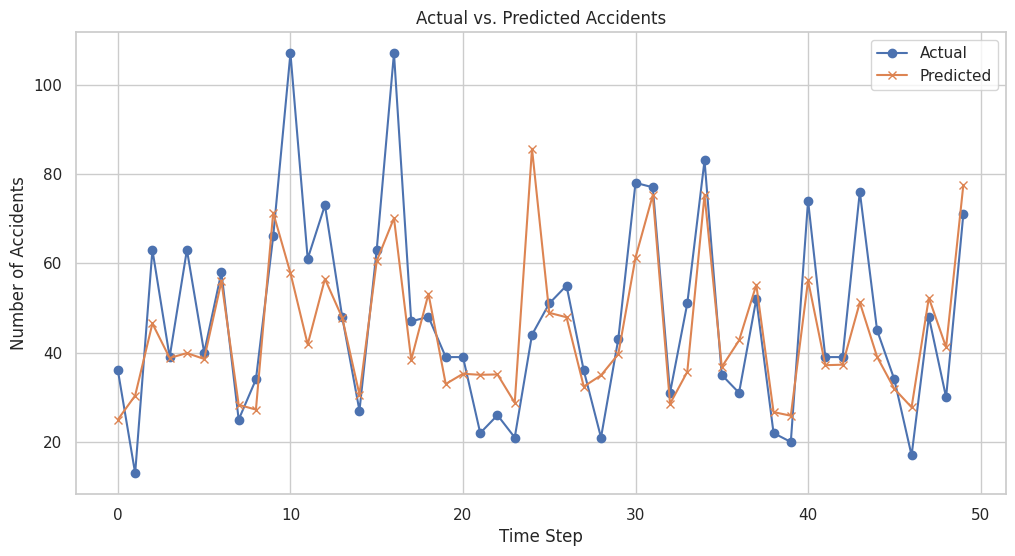

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label='Actual', marker='o')
plt.plot(predicted, label='Predicted', marker='x')
plt.title('Actual vs. Predicted Accidents')
plt.xlabel('Time Step')
plt.ylabel('Number of Accidents')
plt.legend()
plt.grid(True)
plt.show()